In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils

In [3]:
include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/GraphPlottingBFS/dviWk.ji for GraphPlottingBFS [277fd268-772f-11e9-01e2-fbbcabd1ad4a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/PGFPlotsX/ckKEQ.ji for PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1190


# Experiments:

Generate 4 environments for all experiments

In [ ]:
# env_graphs = []
# envs = []
# num_obstacle_cells = 64
# for (i,n) in enumerate([2,4,8])
#     obs_w = Int(sqrt(num_obstacle_cells)/n)
#     env = construct_regular_factory_world(;
#         n_obstacles_x=n,
#         n_obstacles_y=n,
#         obs_width = [obs_w;obs_w],
#         obs_offset = [obs_w;obs_w],
#         env_pad = [1;1],
#         env_offset = [1,1],
#         env_scale = 1 # this is essentially the robot diameter
#     )
#     filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml")
#     open(filename,"w") do io
#         TOML.print(io,env)
#     end
#     # graphics_filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".svg")
#     # visualize_env(env) |> SVG(graphics_filename)
#     push!(envs, env)
# end

In [ ]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename);
env_graph = factory_env.graph;
dist_matrix = get_dist_matrix(env_graph);
p = visualize_env(factory_env)
# p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

# Record Video

In [ ]:
problem_id = 134
results_filename = joinpath(RESULTS_DIR,string(:full_solver),string("results",problem_id,".toml"))
toml_dict = TOML.parsefile(results_filename);
robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
# object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
# tf = maximum(map(p->length(p),robot_paths))
# set_default_plot_size(18cm,18cm)
# record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),t->render_paths(t,robot_paths,object_paths);tf=tf)

# Load results into dataframes

In [5]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = RESULTS_DIR
# results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
config_df = construct_config_dataframe(problem_dir,N_problems);

In [6]:
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)

Dict{Symbol,DataFrame} with 4 entries:
  :full_solver                     => 250×15 DataFrame. Omitted printing of 10 …
  :low_level_search_with_repair    => 0×11 DataFrame…
  :assignment_only                 => 0×10 DataFrame…
  :low_level_search_without_repair => 0×11 DataFrame…

# Display experimental results

In [4]:
# preprocessing
function preprocess_results!(df_dict)
    for (k,df) in df_dict
        begin df[!,:depth_bias_string] = string.(df.depth_bias)
            df
        end
        begin df[!,:N_string] = string.(df.N)
            df
        end
        sort!(df, (:M,:N))
    end
    df_dict
end

preprocess_results! (generic function with 1 method)

In [5]:
function robots_vs_task_vs_time_box_plot(df;
        title="Solution time by Number of Robots (N) and Number of Tasks (M)",
        yticks=[-1,0,1,2],
        ymin=-1.5,
        ymax=2.3
    )
    latex_fonts = Theme(major_label_font="CMU Serif", major_label_font_size=16pt,
                    minor_label_font="CMU Serif", minor_label_font_size=12pt,
                    key_title_font="CMU Serif", key_title_font_size=12pt,
                    key_label_font="CMU Serif", key_label_font_size=12pt)
    
    plot(df, xgroup=:M, x=:N_string, y=:time, color=:N_string,
    Geom.subplot_grid(
        Geom.boxplot(;suppress_outliers=true),
        Coord.cartesian(; ymin=ymin, ymax=ymax),
        Guide.yticks(;ticks=yticks),
        Guide.xticks(;label=false),
#         Guide.xlabel("Num Robots",orientation=:horizontal),
        ),
    Guide.title(title),
    Guide.colorkey(title="number of robots", labels=["10","20","30","40"], pos=[0.1w,-0.32h]),
    Scale.group_discrete(labels=M->string(M," Tasks"),levels=[10,20,30,40,60]),
    Guide.xlabel("number of tasks"),
    Guide.ylabel("computation time (s)"),
    Scale.y_log10(),
    latex_fonts
)
end
set_default_plot_size(20cm,12cm)

In [ ]:
# p1 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; 
#     title="Full Algorithm")
# # p1 |> PDF("FullAlgorithm.pdf", 20cm, 12cm)
# # p1

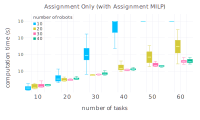

In [42]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = RESULTS_DIR
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict)
p1 = robots_vs_task_vs_time_box_plot(df_dict[:assignment_only]; title="Assignment Only (with Assignment MILP)")

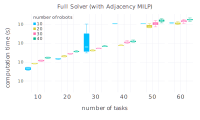

In [47]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict)
p2 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; title="Full Solver (with Adjacency MILP)")

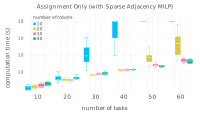

In [46]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict)
p3 = robots_vs_task_vs_time_box_plot(df_dict[:assignment_only]; title="Assignment Only (with Sparse Adjacency MILP)")

In [ ]:
# set_default_plot_size(20cm,9cm)
# p3 = robots_vs_task_vs_time_box_plot(
#     df_dict[:low_level_search_with_repair];title=nothing,yticks=[-1,0,1],ymin=-1.5,ymax=0.2)

In [ ]:
using PGFPlotsX
latexengine!(PGFPlotsX.PDFLATEX)
using Printf

In [ ]:
function get_runtime_box_plot(df;obj=:time,m_range=10:10:60,n_range=10:10:40,ymin=0.007,title="",nsym="n",msym="m",)
    @pgf gp = GroupPlot({group_style = { 
                "group name"="myPlots",
                "group size"="6 by 1",
                "xlabels at"="edge bottom",
                "xticklabels at"="edge bottom",
                "vertical sep"="0pt",
                "horizontal sep"="2pt"
            },
            boxplot,
            "boxplot/draw direction"="y",
            # axis lines=left,
            # hide axis,
            ymode="log",
            footnotesize,
            width="3.25cm",
            height="6cm",
            xmin=0, 
            xmax=5,
            ymin=ymin,
            ymax=120,
            xtick=[10,20,30,40],
            xticklabels=[10,20,30,40],
            tickpos="left",
            ytick=[0.1,1,10,100],
            yticklabels=[],
            "ylabel shift"="0pt",
            "ytick align"="outside",
            "xtick align"="outside"});

    @pgf for (i,m) in enumerate(m_range)
        if i == 1
            push!(gp, 
                {xlabel=@sprintf("\$%s=%i\$",msym,m),
                ylabel="time (s)",
                yticklabels=[0.1,1,10,100],
                "legend style"="{draw=none,xshift=2pt}",
                "legend pos"="north west"},
                map(n->LegendEntry({},@sprintf("\$%s=%i\$",nsym,n),false),n_range)...,
                """
                \\addlegendimage{no markers,blue}
                \\addlegendimage{no markers,red}
                \\addlegendimage{no markers,brown}
                \\addlegendimage{no markers,black}
                """,
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df.M .== m) .& (df.N .== n),obj]])),n_range)...)
        else
            push!(gp, {xlabel=@sprintf("\$%s=%i\$",msym,m)}, 
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df.M .== m) .& (df.N .== n),obj]])),n_range)...)
        end
    end;
    if title != ""
        tikzpic = @pgf TikzPicture({scale=0.7},
            """
            \\centering
            """,
            gp,
            @sprintf("""
            \\node (title) at (\$(myPlots c1r1.center)!0.5!(myPlots c2r1.center)+(3.3cm,2.55cm)\$) {\\textbf{%s}};
            """,title)
        )
    else
        tikzpic = @pgf TikzPicture({scale=0.7},
            """
            \\centering
            """,
            gp
        )
    end
    return tikzpic
end

# print_tex(gp)

In [ ]:
# mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
mode_list = [:full_solver]
tmin = minimum(map(MODE->minimum(df_dict[MODE].time),mode_list))

In [ ]:
# gp = get_runtime_box_plot(df_dict[:full_solver];ymin=tmin)

In [ ]:
# titles = Dict(
#     :full_solver => "Runtime of Full \\PCTAPF{} Solver",
#     :assignment_only => "Runtime of Task Assignment MILP Solver",
#     :low_level_search_with_repair => "Runtime of \\LevelThreeLong{}",
#     :low_level_search_without_repair => "Runtime of \\LevelThreeLong{}",
# )
titles = Dict(
    :full_solver => "Experimental Results (Runtime)",
    :assignment_only => "",
    :low_level_search_with_repair => "",
    :low_level_search_without_repair => "",
)
for MODE in [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
    gp = get_runtime_box_plot(df_dict[MODE];ymin=tmin,title=titles[MODE])
#     open(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics",string(MODE,".tex")),"w") do io
    open(string(MODE,".tex"),"w") do io
        print_tex(io, gp)
    end
end